In [3]:
# Import all data visualisation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import ipywidgets as ipy
from IPython.display import Image

sns.set_theme()
sns.set_palette("colorblind")
sns.set_style('whitegrid')
%matplotlib inline

## Loading Data

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('data/output_data.csv', parse_dates = ['date'])
df = df.set_index('date')
df = df.asfreq('B')
df = df.sort_index()

start_train = '2017-08-01'
end_train = '2022-09-01'
start_test = '2022-09-01'
end_test = '2023-05-01'
timedelta_test = datetime.strptime(end_test, '%Y-%m-%d') - datetime.strptime(start_test, '%Y-%m-%d')
 
X_train = df.loc[start_train:end_train]
X_test = df.loc[start_test:end_test]

X_train.shape, X_test.shape

# Extract all column name starting by 'close'
targets = [col for col in df.columns if col.startswith('Close')]

## Preprocessing pipeline 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

### Infinites values

In [6]:
def replace_infinities(X):
    return X.replace([np.inf, -np.inf], np.nan)

replace_infinities_transformer = FunctionTransformer(replace_infinities)


### null standard deviation

In [7]:
def drop_zero_std(X):
    zero_std_mask = np.std(X, axis=0) != 0
    return X[:, zero_std_mask]

drop_zero_std = FunctionTransformer(drop_zero_std)

### Outliers

In [8]:
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt

def plot(column):
    if df[column].dtype in ['int64', 'float64']:
        sns.boxplot(x=df[column])
    else:
        sns.countplot(x=df[column])
    plt.show()

interact(plot, column=df.columns.tolist())

interactive(children=(Dropdown(description='column', options=('btc_tweet_count', 'eth_tweet_count', 'bnb_tweet…

<function __main__.plot(column)>

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold, verbose=False):
        self.threshold = threshold
        self.verbose = verbose

    def fit(self, X, y=None):
        self.median_ = X.median()
        self.iqr_ = X.quantile(0.75) - X.quantile(0.25)
        return self

    def transform(self, X, y=None):
        X_new = X[~((X < (self.median_ - self.threshold * self.iqr_)) | (X > (self.median_ + self.threshold * self.iqr_))).any(axis=1)]
        if self.verbose:
            print(f"Removed {X.shape[0] - X_new.shape[0]} rows")
        return X_new

threshold = 10
OutlierRemover(threshold = threshold, verbose = True).fit_transform(X_train)

outlier_remover = OutlierRemover(threshold = threshold)

Removed 243 rows


### Missing data

In [10]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()

# Display total number of missing values per column before imputation
print("Missing values before imputation:")
print(X_train.isna().sum().sort_values())

Missing values before imputation:
btc_tweet_count                        0
crisis_posts_count                     0
sdcc_vader_polarity_compound_mean      0
sdcc_vader_polarity_compound_max       0
sdcc_vader_polarity_compound_min       0
                                    ... 
Volume_SOL                           778
Close_DOT                            786
Volume_DOT                           786
Close_SHIB                           972
Volume_SHIB                          972
Length: 200, dtype: int64


### Numerical data

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f'Numeric columns : {len(numeric_columns)}')

Numeric columns : 200


### No categorical data

#### Preprocessing pipeline 

In [13]:
std = StandardScaler()
pca = PCA(n_components=70)

preprocessor = Pipeline(steps=[
    ('replace_infinities', replace_infinities_transformer),
    ('outlier_remover', OutlierRemover(threshold=40, verbose=True)),
    ('imputer', KNNImputer()),
    ('remove_zero_std', drop_zero_std),
    ('scaler', std),
    ('pca', pca)
])

# preprocessor

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def score(y_pred, y_test):
    """Return MSE, RMSE, MAE, MAPE, R2"""
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, mae, mape, r2

In [15]:
def plot_pred_value(y_train, y_pred, y_test, target_name, model_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(y_train, label='Training data')
    ax.plot(y_test, label='Observations')
    ax.plot(y_pred, label='Predictions')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
    ax.set_xlabel('Date')
    ax.set_ylabel('')

    ax.set_title(f'Prediction on {target_name[5:]} value using {model_name}')
    ax.legend()
    plt.show()

In [16]:
def plot_pred_growth(y_train, y_pred, y_test, target_name, model_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(y_train, label='Train')
    ax.plot(y_test, label='Test')
    ax.plot(y_pred, label='Predicted')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
    ax.set_xlabel('Date')
    ax.set_ylabel('')

    ax.set_title(f'Prediction on {target_name[5:]} value using {model_name}')
    ax.legend()
    plt.show()

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_model(X_train, y_train):
    """Train Sarimax model"""
    model = SARIMAX(y_train, X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit()

    return model_fit

In [18]:
import pickle

def save_model(model, model_name, target_name):
    """Save model using Pickle"""
    model.save(f'models/{model_name}_{target_name}.pkl')

In [20]:
X_test_preprocessed.shape

# Timedelta start_test - end_test
datetime.strptime(end_test, '%Y-%m-%d') - datetime.strptime(start_test, '%Y-%m-%d')

NameError: name 'X_test_preprocessed' is not defined

Shape of X_train_preprocessed: (1316, 70)
Shape of y_train: (1316,)


/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46383D+00    |proj g|=  6.93322D-02

At iterate    5    f=  8.43651D+00    |proj g|=  1.47926D-02

At iterate   10    f=  8.43338D+00    |proj g|=  3.09018D-04

At iterate   15    f=  8.43314D+00    |proj g|=  3.11674D-03

At iterate   20    f=  8.33703D+00    |proj g|=  3.89682D-03

At iterate   25    f=  8.33691D+00    |proj g|=  6.99167D-03

At iterate   30    f=  8.33655D+00    |proj g|=  2.17839D-04

At iterate   35    f=  8.33652D+00    |proj g|=  9.35436D-04

At iterate   40    f=  8.33469D+00    |proj g|=  2.49979D-02

At iterate   45    f=  8.33386D+00    |proj g|=  2.45738D-04


/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.33310D+00    |proj g|=  5.27686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   75     50     73      1     0     0   5.277D-03   8.333D+00
  F =   8.3331048479902137     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
_BTC: MSE=9866033.90, RMSE=3141.02, MAE=2352.44, MAPE=13.07, R2=-0.13


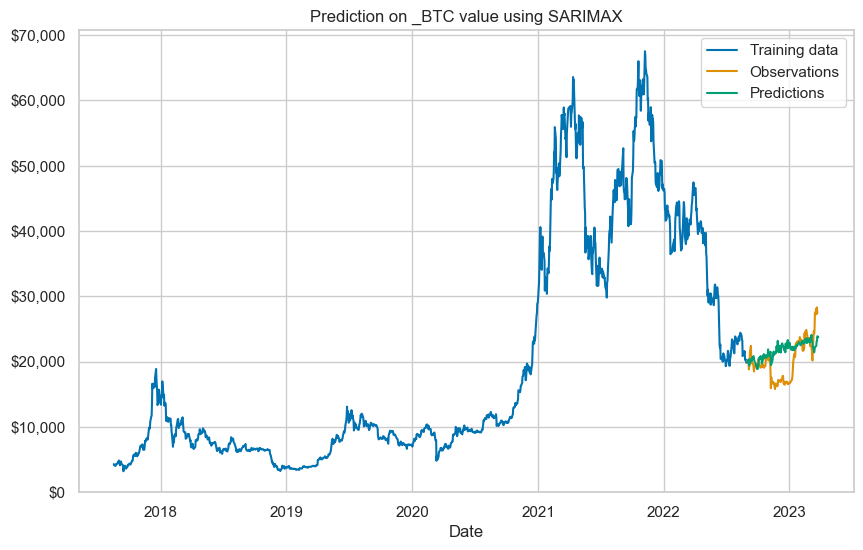

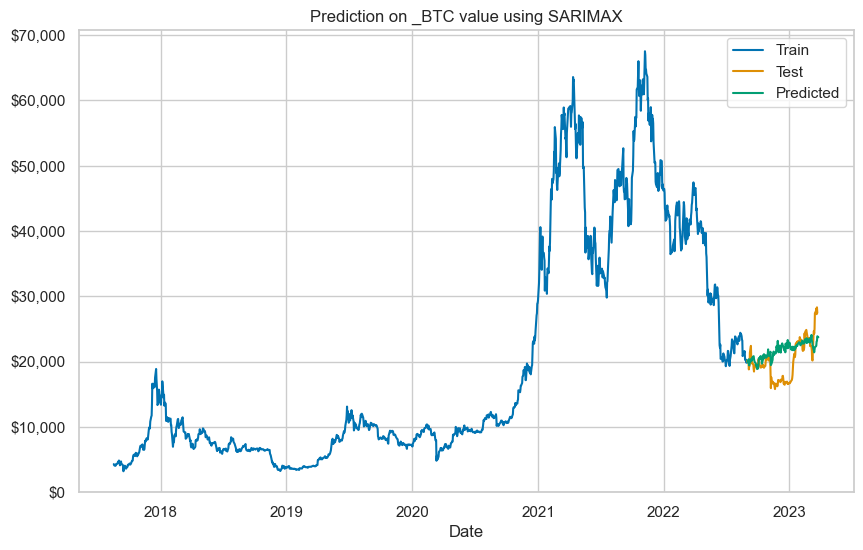

Shape of X_train_preprocessed: (1316, 70)
Shape of y_train: (1316,)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91613D+00    |proj g|=  6.90270D-02

At iterate    5    f=  5.89227D+00    |proj g|=  9.20189D-03

At iterate   10    f=  5.78949D+00    |proj g|=  4.96603D-02

At iterate   15    f=  5.78752D+00    |proj g|=  1.36636D-02

At iterate   20    f=  5.77910D+00    |proj g|=  1.94348D-02

At iterate   25    f=  5.77833D+00    |proj g|=  4.88222D-03

At iterate   30    f=  5.77726D+00    |proj g|=  2.37485D-03

At iterate   35    f=  5.77721D+00    |proj g|=  3.17664D-03

At iterate   40    f=  5.77668D+00    |proj g|=  5.54882D-03

At iterate   45    f=  5.77655D+00    |proj g|=  2.03021D-03

At iterate   50    f=  5.77648D+00    |proj g|=  1.60762D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


_ETH: MSE=77507.69, RMSE=278.40, MAE=228.39, MAPE=17.79, R2=-1.26


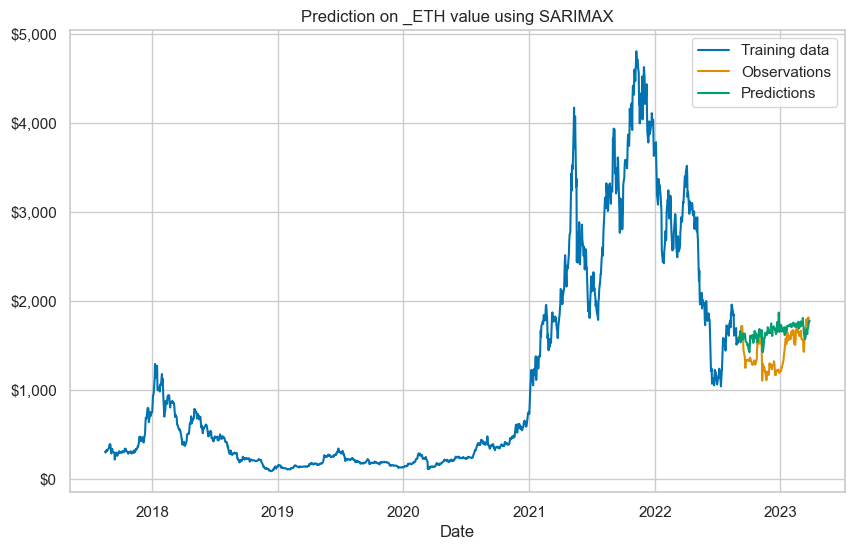

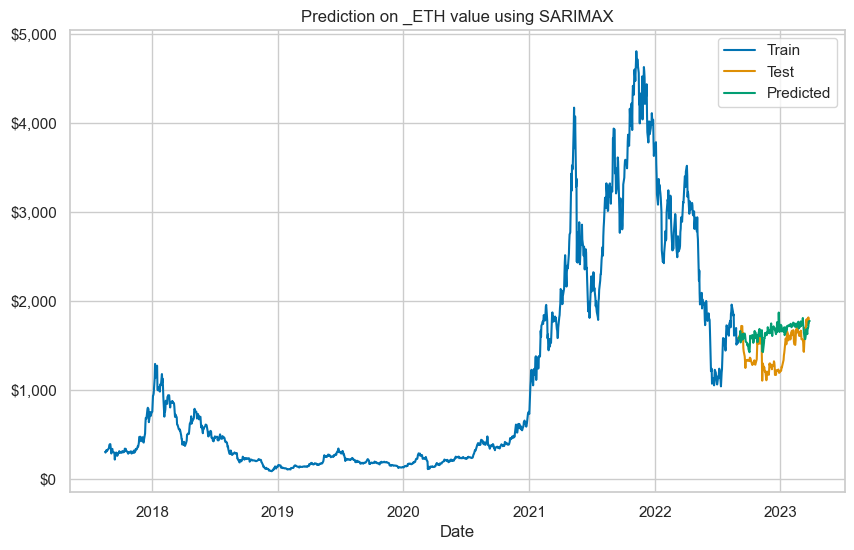

Shape of X_train_preprocessed: (1316, 70)
Shape of y_train: (1316,)


/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53050D+00    |proj g|=  7.82087D+00


 This problem is unconstrained.



At iterate    5    f= -1.54792D+00    |proj g|=  1.03110D+00

At iterate   10    f= -1.54820D+00    |proj g|=  5.35291D-01

At iterate   15    f= -1.54822D+00    |proj g|=  5.41562D-01
  ys=-6.822E-08  -gs= 2.280E-06 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   75     18     51      1     1     0   1.013D+00  -1.548D+00
  F =  -1.5482223449559498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
_DOGE: MSE=0.00, RMSE=0.06, MAE=0.05, MAPE=62.46, R2=-11.88


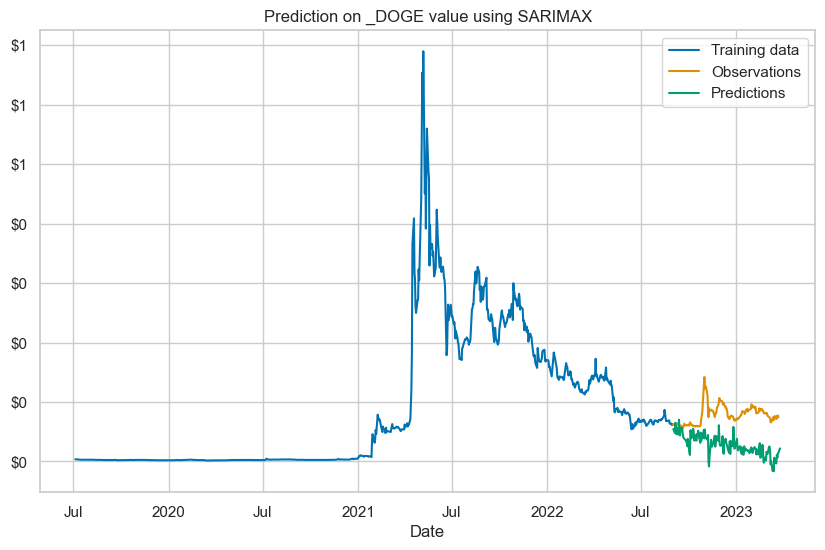

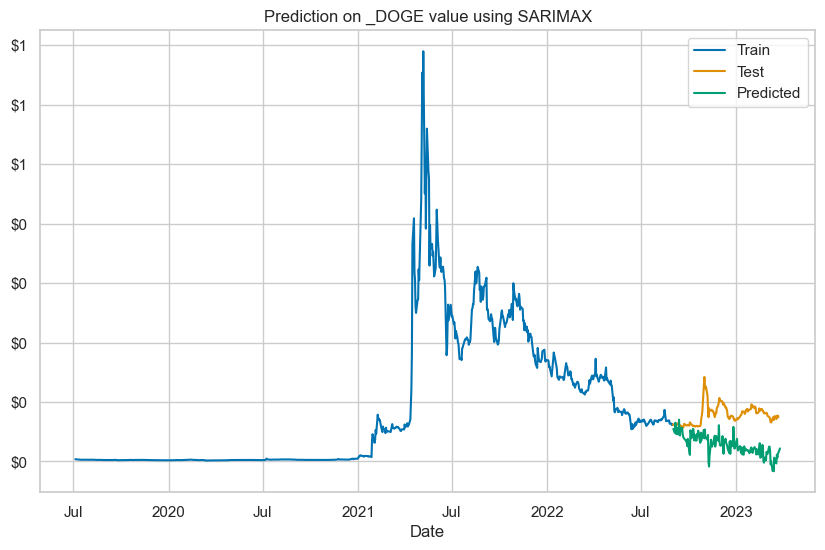

Shape of X_train_preprocessed: (1316, 70)
Shape of y_train: (1316,)


/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.47248D+00    |proj g|=  9.71755D+07


 This problem is unconstrained.
/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   75      1     21      1     0     0   9.718D+07  -1.472D+00
  F =  -1.4724802476133541     

ABNORMAL_TERMINATION_IN_LNSRCH                              
_SHIB: MSE=0.00, RMSE=0.00, MAE=0.00, MAPE=16199.78, R2=-5198185.24


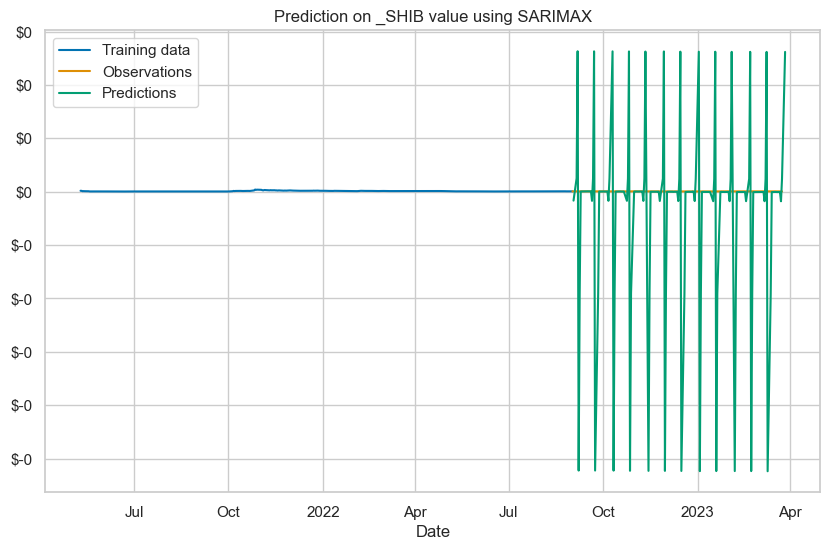

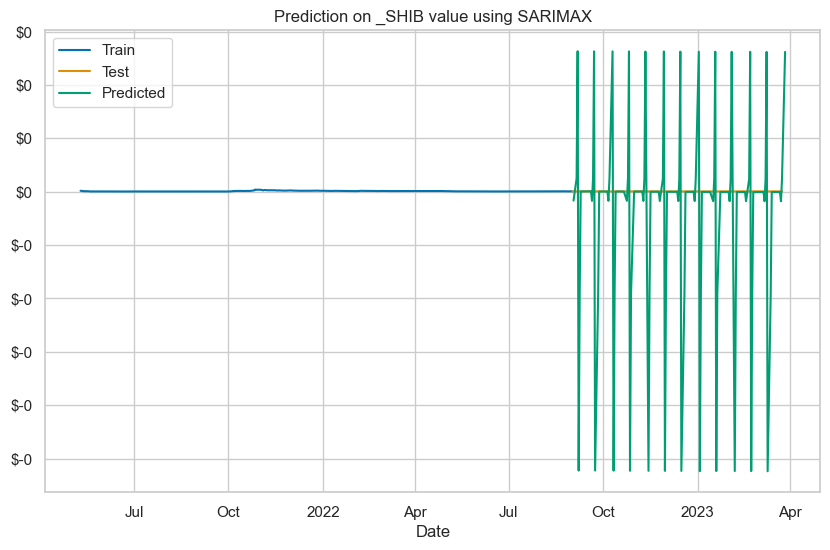

Shape of X_train_preprocessed: (1316, 70)
Shape of y_train: (1316,)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41241D-01    |proj g|=  5.77780D-02


 This problem is unconstrained.



At iterate    5    f=  8.08379D-01    |proj g|=  1.49008D-02

At iterate   10    f=  8.00403D-01    |proj g|=  5.28496D-03

At iterate   15    f=  7.98575D-01    |proj g|=  6.30965D-03

At iterate   20    f=  7.97992D-01    |proj g|=  1.16038D-03

At iterate   25    f=  7.97872D-01    |proj g|=  6.38663D-04

At iterate   30    f=  7.97842D-01    |proj g|=  4.53460D-04

At iterate   35    f=  7.97803D-01    |proj g|=  3.84094D-04

At iterate   40    f=  7.97782D-01    |proj g|=  4.58097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   75     43     59      1     0     0   3.565D-04   7.978D-01
  F =  0.797776183771

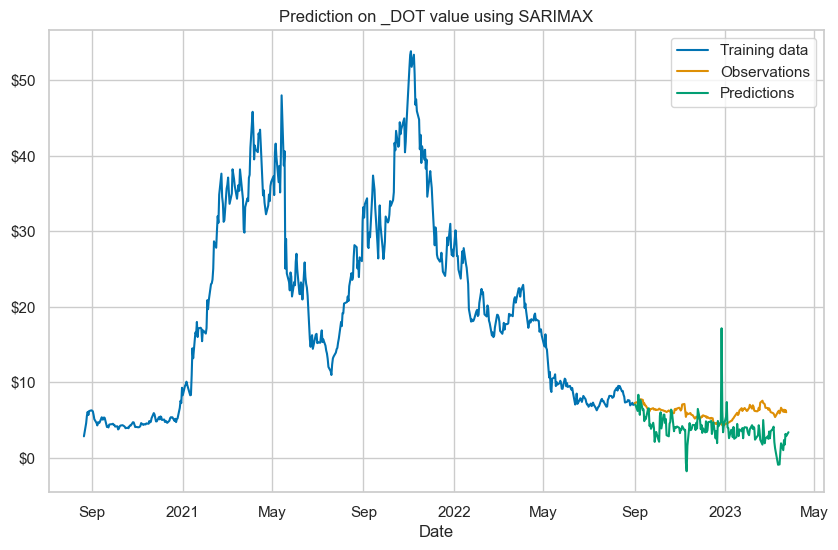

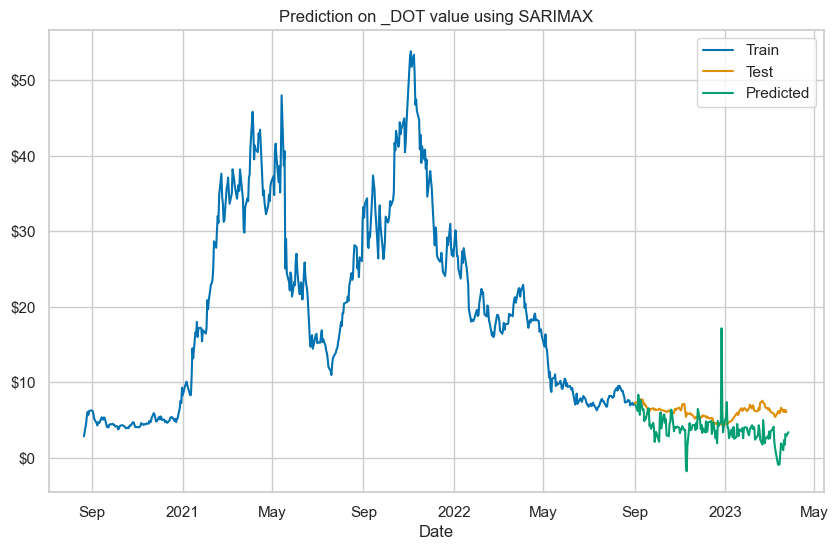

Shape of X_train_preprocessed: (1316, 70)
Shape of y_train: (1316,)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82415D+00    |proj g|=  4.29622D-02


 This problem is unconstrained.



At iterate    5    f=  2.79939D+00    |proj g|=  5.21249D-03

At iterate   10    f=  2.75434D+00    |proj g|=  5.61813D-02

At iterate   15    f=  2.74330D+00    |proj g|=  2.01561D-03

At iterate   20    f=  2.74168D+00    |proj g|=  7.01826D-04

At iterate   25    f=  2.74161D+00    |proj g|=  4.09857D-04

At iterate   30    f=  2.74159D+00    |proj g|=  3.96590D-04

At iterate   35    f=  2.74158D+00    |proj g|=  2.78810D-04

At iterate   40    f=  2.74157D+00    |proj g|=  7.31124D-05

At iterate   45    f=  2.74156D+00    |proj g|=  1.25268D-04

At iterate   50    f=  2.74155D+00    |proj g|=  9.48951D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


_BCH: MSE=4439.44, RMSE=66.63, MAE=57.45, MAPE=48.26, R2=-31.31


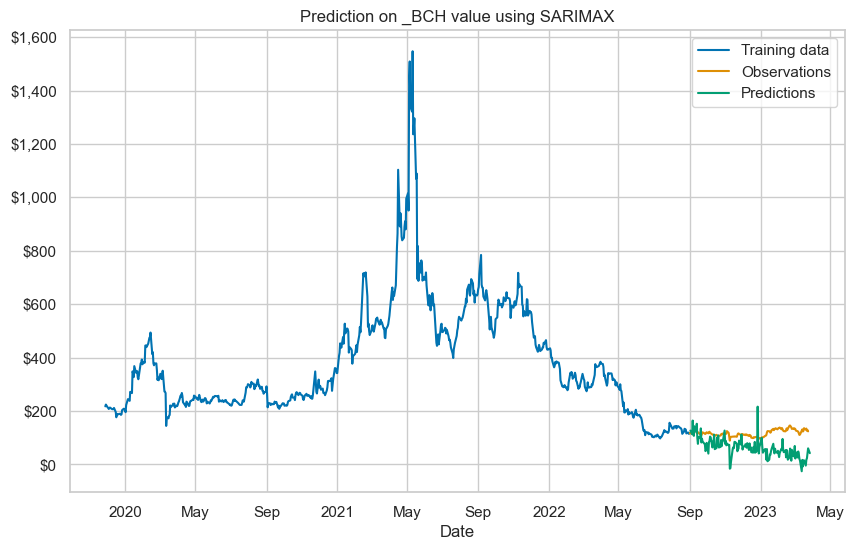

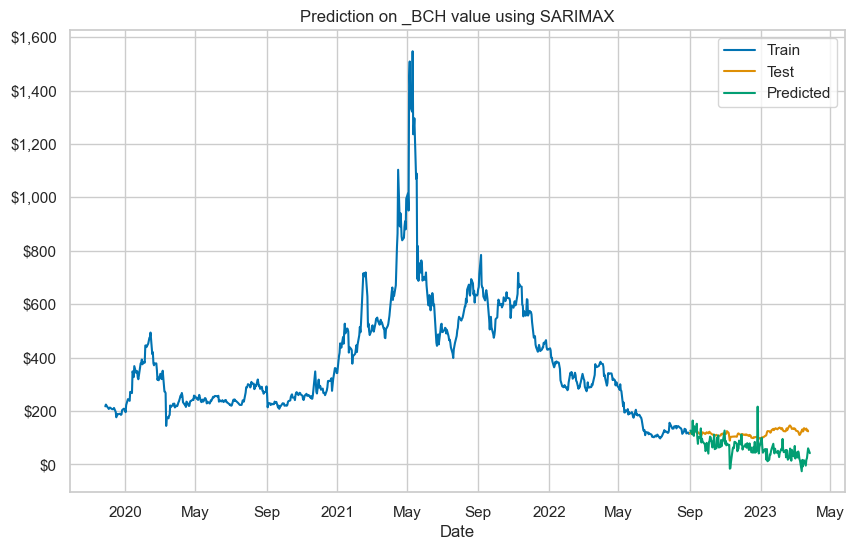

Shape of X_train_preprocessed: (1316, 70)
Shape of y_train: (1316,)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34771D+00    |proj g|=  2.53559D-02


 This problem is unconstrained.



At iterate    5    f=  1.30771D+00    |proj g|=  9.99246D-03

At iterate   10    f=  1.30378D+00    |proj g|=  4.17159D-03

At iterate   15    f=  1.30291D+00    |proj g|=  1.57937D-03

At iterate   20    f=  1.30257D+00    |proj g|=  1.81883D-03

At iterate   25    f=  1.30239D+00    |proj g|=  2.73505D-03

At iterate   30    f=  1.30227D+00    |proj g|=  2.00106D-03

At iterate   35    f=  1.30221D+00    |proj g|=  3.03071D-04

At iterate   40    f=  1.30217D+00    |proj g|=  3.33461D-04

At iterate   45    f=  1.30214D+00    |proj g|=  3.28003D-04


/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.30210D+00    |proj g|=  2.11413D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   75     50     55      1     0     0   2.114D-04   1.302D+00
  F =   1.3021029636382413     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
_SOL: MSE=310.85, RMSE=17.63, MAE=15.04, MAPE=91.20, R2=-4.26


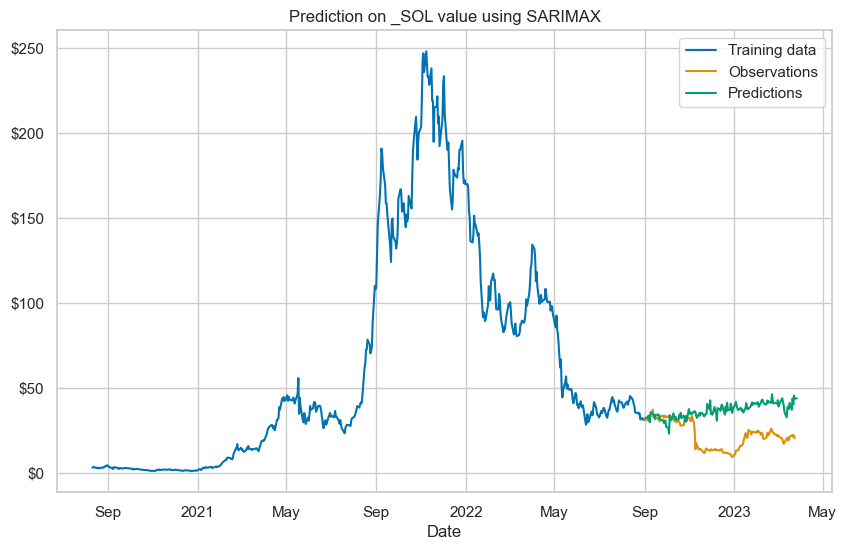

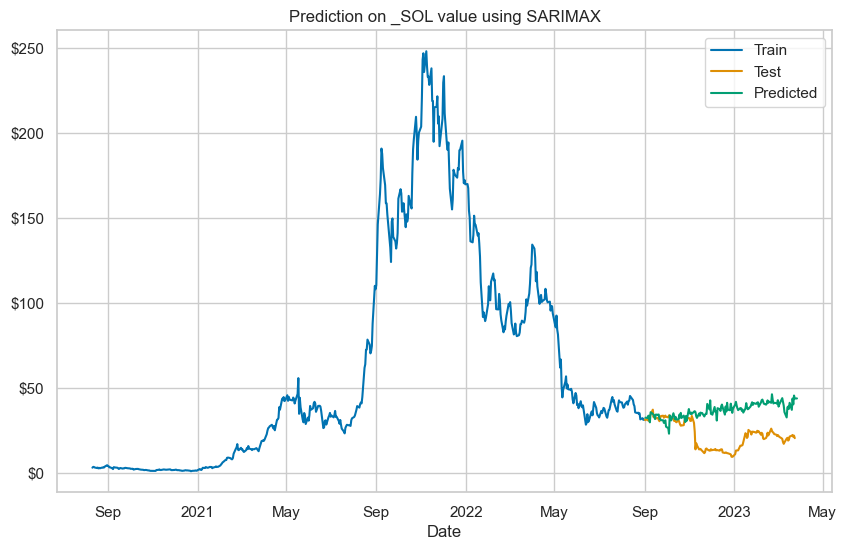

Shape of X_train_preprocessed: (1316, 70)
Shape of y_train: (1316,)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.72489D-01    |proj g|=  1.67586D+00


 This problem is unconstrained.



At iterate    5    f= -4.95421D-01    |proj g|=  9.10358D-02

At iterate   10    f= -4.96443D-01    |proj g|=  1.08055D-01

At iterate   15    f= -4.98273D-01    |proj g|=  1.70303D-01

At iterate   20    f= -5.06831D-01    |proj g|=  2.00811D-01

At iterate   25    f= -5.08982D-01    |proj g|=  3.47372D-01

At iterate   30    f= -5.09792D-01    |proj g|=  8.08601D-02

At iterate   35    f= -5.09885D-01    |proj g|=  6.76800D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   75     38     68      1     0     0   7.113D-02  -5.099D-01
  F = -0.50990477706010340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


_ADA: MSE=0.01, RMSE=0.08, MAE=0.06, MAPE=20.00, R2=-0.87


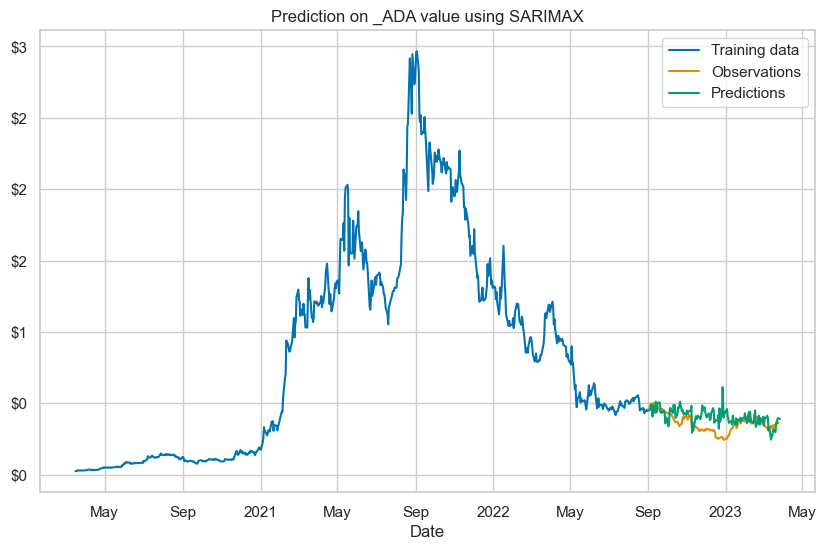

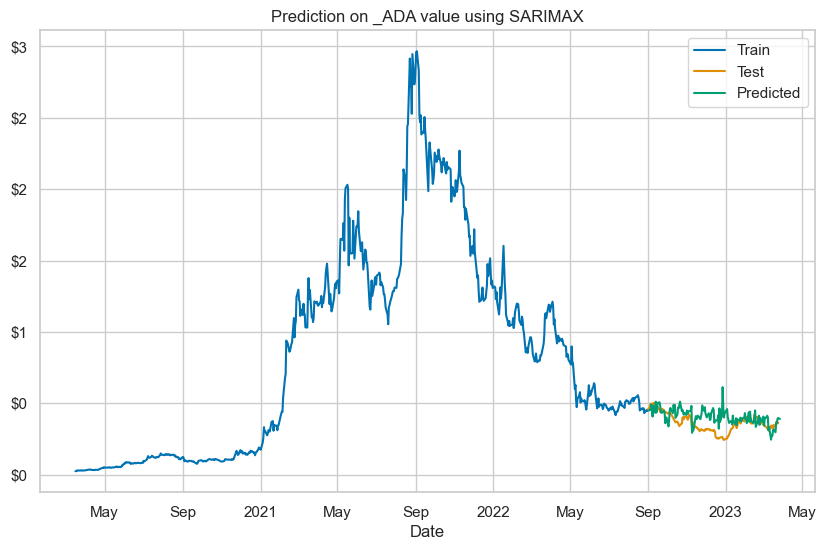

Shape of X_train_preprocessed: (1316, 70)
Shape of y_train: (1316,)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.34610D-01    |proj g|=  2.72890D+00

At iterate    5    f= -6.82721D-01    |proj g|=  1.19665D-01

At iterate   10    f= -6.83947D-01    |proj g|=  1.05651D-01

At iterate   15    f= -6.88888D-01    |proj g|=  3.45104D-01

At iterate   20    f= -6.95278D-01    |proj g|=  4.15907D-01

At iterate   25    f= -6.96164D-01    |proj g|=  3.20556D-02

At iterate   30    f= -6.96240D-01    |proj g|=  4.42380D-02

At iterate   35    f= -6.96301D-01    |proj g|=  3.16979D-02

At iterate   40    f= -6.96383D-01    |proj g|=  1.58091D-01

At iterate   45    f= -6.96924D-01    |proj g|=  1.25474D-01

At iterate   50    f= -7.00999D-01    |proj g|=  2.66490D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mathisderenne/Mon Drive/04 - Projet/RennesDataChallenge/DataChallenge2023/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


_MATIC: MSE=0.03, RMSE=0.18, MAE=0.13, MAPE=12.67, R2=-0.01


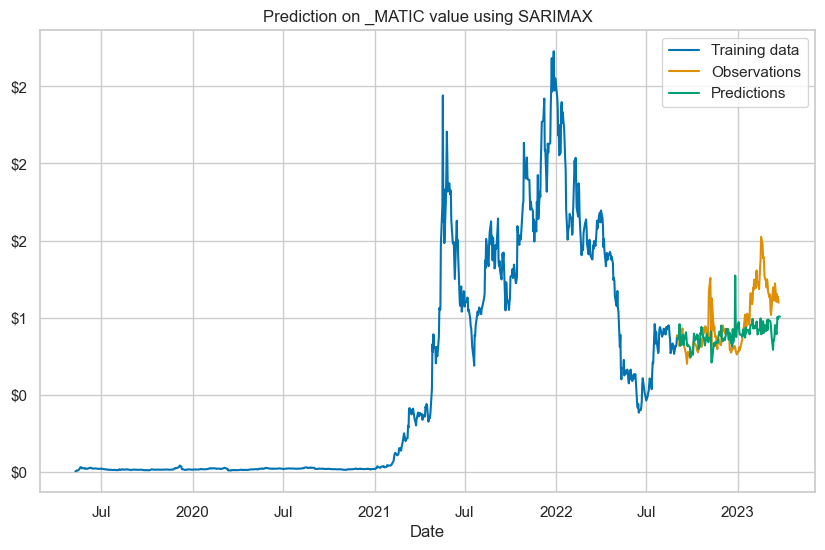

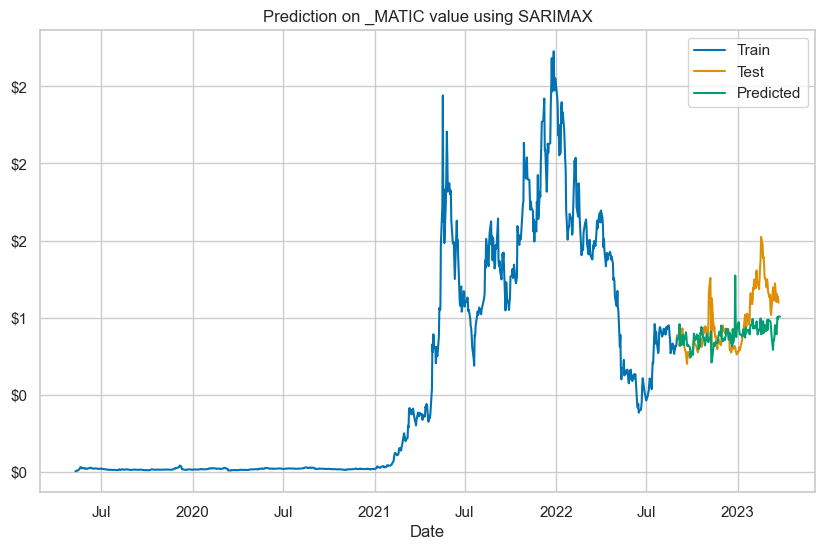

Shape of X_train_preprocessed: (1316, 70)
Shape of y_train: (1316,)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           75     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99041D+00    |proj g|=  5.23773D-02


 This problem is unconstrained.


KeyboardInterrupt: 

In [ ]:
targets_name = [target[5:] for target in targets]
pred_results = pd.DataFrame(columns = 
    [target_name + '_real' for target_name in targets_name] + 
    [target_name + '_pred' for target_name in targets_name], index = X_test.index)

for target in targets:
    model_name = 'SARIMAX'
    target_name = target[5:]
    
    # Make X_train start at the start of X_train[target]
    
    y_train = X_train[target]
    y_test = X_test[target]
    
    X_train_preprocessed = X_train.drop(columns=target)
    X_test_preprocessed = X_test.drop(columns=target)
    
    X_train_preprocessed = preprocessor.fit_transform(X_train_preprocessed)
    X_test_preprocessed = preprocessor.transform(X_test_preprocessed)
    
    print("Shape of X_train_preprocessed:", X_train_preprocessed.shape)
    print("Shape of y_train:", y_train.shape)
    
    model_fit = train_model(X_train_preprocessed, y_train)
    
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog = X_test_preprocessed)
    
    mse, rmse, mae, mape, r2 = score(y_pred, y_test)
    print(f'{target[5:]}: MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}, R2={r2:.2f}')
    
    plot_pred_value(y_train, y_pred, y_test, target, 'SARIMAX')
    plot_pred_growth(y_train, y_pred, y_test, target, 'SARIMAX')
    
    save_model(model_fit, model_name, target_name)
    
    pred_results[target_name + '_real'] = y_test
    pred_results[target_name + '_pred'] = y_pred
    
pred_results.to_csv('data/pred_results.csv', index=True)

NameError: name 'pred_results' is not defined